<a href="https://colab.research.google.com/github/azuse/AdvancedGearSimulator/blob/master/DCGAN_on_CIFAR10_modefied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torchvision-0.3.0-{platform}-linux_x86_64.whl
!pip3 install "pillow<7"

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

  ERROR: HTTP error 404 while getting https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
  ERROR: Could not install requirement torch==1.1.0 from https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl because of error 404 Client Error: Not Found for url: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
ERROR: Could not install requirement torch==1.1.0 from https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl because of HTTP error 404 Client Error: Not Found for url: https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl for URL https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
  ERROR: HTTP error 404 while getting https://mirrors.tuna.tsinghua.edu.cn/

Parameter Settings
-------------------


In [0]:
latent_dims = 10
num_epochs = 20
batch_size = 256
learning_rate = 2e-4
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


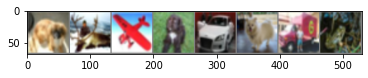

  dog  deer plane   dog   car   dog truck  frog


In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, 1024, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1) # in-depth=3 out-depth=128 stride=4 padding=2 dilation=1
                                # 省略一次batch nomorlization，避免样本震荡和模型不稳定
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

    def forward(self, input):
        print("input"+x.size())
        x = F.leaky_relu(self.conv1(input), 0.2)  # 对于鉴别器，使用leaky_relu （使用relu可以避免梯度消失）
        print("covn1"+x.size())
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print("covn2"+x.size())
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print("covn3"+x.size())
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        print("covn4"+x.size())
        x = torch.sigmoid(self.conv5(x))
        print("covn5"+x.size())

        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12660355 and discriminator: 11038081


Train GAN
--------


In [10]:
## Add a image show function to display in training
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# with torch.no_grad():

#     # sample latent vectors from the standard normal distribution
#     latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
#     fake_image_batch = generator(latent)
#     fake_image_batch = fake_image_batch.cpu()

#     fig, ax = plt.subplots(figsize=(8, 8))
#     show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
#     plt.show()



# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()


gen_loss_avg = []
disc_loss_avg = []

print('Training Discriminator ...')
for epoch in range(20):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        import sys
        sys.stdout.write(".")
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device) # real=1
        label_fake = torch.zeros(image_batch.size(0), device=device) # fake=0

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        # print("====Discriminator==== Loss={}".format(disc_loss.cpu().detach()))
        
        # # show images
        if num_batches % 100 == 0:
          imshow(torchvision.utils.make_grid(image_batch[0:8].cpu()))
          print("label_real:" + ' '.join(str(label_real.cpu().detach().numpy()[j])  for j in range(8)))
          print('real_pred:'+' '.join(str(real_pred.cpu().detach().numpy()[j])  for j in range(8)))


          imshow(torchvision.utils.make_grid(fake_image_batch[0:8].cpu().detach()))
          print('label_fake:'+" ".join(str(label_fake.cpu().detach().numpy()[j]) for j in range(8)))
          print('fake_pred:'+" ".join(str(fake_pred.cpu().detach().numpy()[j]) for j in range(8)))

        # train generator to output an image that is classified as real
        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        # # show images
        # print("====Generator====  Loss={}".format(gen_loss.cpu().detach()))
        if num_batches % 100 == 0:
          imshow(torchvision.utils.make_grid(fake_image_batch[0:8].cpu().detach()))
          print('label_real:'+" ".join(str(label_real.cpu().detach().numpy()[j]) for j in range(8)))
          print('fake_pred:'+" ".join(str(fake_pred.cpu().detach().numpy()[j]) for j in range(8)))
        
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
    
# generator.train(True)
# discriminator.train(False)

# print('Training Generator ...')
# for epoch in range(5):
#     gen_loss_avg.append(0)
#     num_batches = 0
    
#     for image_batch, _ in train_dataloader:
#         import sys
#         sys.stdout.write(".")
#         # get dataset image and create real and fake labels for use in the loss
#         image_batch = image_batch.to(device)
#         label_real = torch.ones(image_batch.size(0), device=device) # real=1
#         label_fake = torch.zeros(image_batch.size(0), device=device) # fake=0

#         # generate a batch of images from samples of the latent prior
#         latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
#         fake_image_batch = generator(latent)
  
        
#         # train generator to output an image that is classified as real
#         fake_pred = discriminator(fake_image_batch.detach()).squeeze()
#         gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
#         gen_optimizer.zero_grad()
#         gen_loss.backward()
#         gen_optimizer.step()
        
#         gen_loss_avg[-1] += gen_loss.item()
#         num_batches += 1

#         # show images
#         imshow(torchvision.utils.make_grid(fake_image_batch[0:8].cpu().detach()))
#         for j in range(8):
#           print('label_real '.join(str(label_real.cpu().numpy()[j]) for j in range(8)))
#           print('fake_pred '.join(str(fake_pred.cpu().numpy()[j]) for j in range(8)))


        
#     gen_loss_avg[-1] /= num_batches
#     print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
#           (epoch+1, num_epochs, gen_loss_avg[-1], 0))
    
# print('Training ...')
# for epoch in range(num_epochs):
#     disc_loss_avg.append(0)
#     num_batches = 0
    
#     for image_batch, _ in train_dataloader:
#         import sys
#         sys.stdout.write(".")
#         # get dataset image and create real and fake labels for use in the loss
#         image_batch = image_batch.to(device)
#         label_real = torch.ones(image_batch.size(0), device=device)
#         label_fake = torch.zeros(image_batch.size(0), device=device)

#         # generate a batch of images from samples of the latent prior
#         latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
#         fake_image_batch = generator(latent)
        
#         # train discriminator to correctly classify real and fake
#         # (detach the computation graph of the generator and the discriminator,
#         # so that gradients are not backpropagated into the generator)
#         real_pred = discriminator(image_batch).squeeze()
#         fake_pred = discriminator(fake_image_batch.detach()).squeeze()
#         disc_loss = 0.5 * (
#             F.binary_cross_entropy(real_pred, label_real) +
#             F.binary_cross_entropy(fake_pred, label_fake))
        
#         disc_optimizer.zero_grad()
#         disc_loss.backward()
#         disc_optimizer.step()
        
#         disc_loss_avg[-1] += disc_loss.item()
#         num_batches += 1
        
#     disc_loss_avg[-1] /= num_batches
#     print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
#           (epoch+1, num_epochs, 0, disc_loss_avg[-1]))
    

# print('Training ...')
# for epoch in range(num_epochs):
#     gen_loss_avg.append(0)
#     num_batches = 0
    
#     for image_batch, _ in train_dataloader:
#         import sys
#         sys.stdout.write(".")
#         # get dataset image and create real and fake labels for use in the loss
#         image_batch = image_batch.to(device)
#         label_real = torch.ones(image_batch.size(0), device=device)
#         label_fake = torch.zeros(image_batch.size(0), device=device)

#         # generate a batch of images from samples of the latent prior
#         latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
#         fake_image_batch = generator(latent)
  
        
#         # train generator to output an image that is classified as real
#         fake_pred = discriminator(fake_image_batch).squeeze()
#         gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
#         gen_optimizer.zero_grad()
#         gen_loss.backward()
#         gen_optimizer.step()
        
#         gen_loss_avg[-1] += gen_loss.item()
#         num_batches += 1
        
#     gen_loss_avg[-1] /= num_batches
#     print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
#           (epoch+1, num_epochs, gen_loss_avg[-1], 0))

.inputtorch.Size([256, 3, 64, 64])
covn1torch.Size([256, 128, 32, 32])
covn2torch.Size([256, 256, 16, 16])
covn3torch.Size([256, 512, 8, 8])
covn4torch.Size([256, 1024, 4, 4])
covn5torch.Size([256, 1, 1, 1])
inputtorch.Size([256, 3, 64, 64])
covn1torch.Size([256, 128, 32, 32])
covn2torch.Size([256, 256, 16, 16])
covn3torch.Size([256, 512, 8, 8])
covn4torch.Size([256, 1024, 4, 4])
covn5torch.Size([256, 1, 1, 1])
inputtorch.Size([256, 3, 64, 64])
covn1torch.Size([256, 128, 32, 32])
covn2torch.Size([256, 256, 16, 16])
covn3torch.Size([256, 512, 8, 8])
covn4torch.Size([256, 1024, 4, 4])
covn5torch.Size([256, 1, 1, 1])
.inputtorch.Size([256, 3, 64, 64])
covn1torch.Size([256, 128, 32, 32])
covn2torch.Size([256, 256, 16, 16])
covn3torch.Size([256, 512, 8, 8])
covn4torch.Size([256, 1024, 4, 4])
covn5torch.Size([256, 1, 1, 1])
inputtorch.Size([256, 3, 64, 64])
covn1torch.Size([256, 128, 32, 32])
covn2torch.Size([256, 256, 16, 16])
covn3torch.Size([256, 512, 8, 8])
covn4torch.Size([256, 1024, 4,

KeyboardInterrupt: ignored

Plot Training Curves
--------------------

In [0]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained GAN
-----------------------------

In [0]:
# import urllib
# if not os.path.isdir('./pretrained'):
#     os.makedirs('./pretrained')
# print('downloading ...')
# urllib.request.urlretrieve ("https://github.com/csinva/gan-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netG_epoch_199.pth", "./pretrained/dcgan.pth")
# urllib.request.urlretrieve ("https://github.com/csinva/gan-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netD_epoch_199.pth", "./pretrained/dcgan_discriminator.pth")
# generator.load_state_dict(torch.load('./pretrained/dcgan.pth'))
# discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))
# print('done')

# this is how the GAN parameters can be saved:
# torch.save(generator.state_dict(), './pretrained/my_dcgan.pth')
# torch.save(discriminator.state_dict(), './pretrained/my_dcgan_discriminator.pth')

Interpolate in Latent Space
----------------------------

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()